# Predict Reviews using Naive Bayes Classifier

importing libraries

In [40]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import data from reviews.csv file

In [6]:
data=pd.read_csv('rt_reviews.csv',encoding='ISO-8859-1')

print the first five rows

In [8]:
data.head(5)

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


identify the data type of the columns

In [12]:
data.dtypes

Freshness    object
Review       object
dtype: object

find the number of unique row for particular columns

In [15]:
data.nunique()

Freshness         2
Review       339697
dtype: int64

find the number of rows with different class labels

In [20]:
data['Freshness'].value_counts()

fresh     240000
rotten    240000
Name: Freshness, dtype: int64

Data processing

converts all the characters to lowercase, removes all numbers, replaces all non-alphanumeric characters with a space, and finally removes any remaining non-alphanumeric characters.



In [19]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[0-9]+', '', sentence)
    sentence = re.sub('\W+',' ', sentence)
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)

    return sentence

cleaning the review column 

In [25]:
data['Review']=data['Review'].map(lambda s: clean_text(s)) 


In [26]:
data.head(5)

,Freshness,Review
0,fresh,manakamana doesn t answer any questions yet m...
1,fresh,wilfully offensive and powered by a chest thu...
2,rotten,it would be difficult to imagine material mor...
3,rotten,despite the gusto its star brings to the role...
4,rotten,if there was a good idea at the core of this ...


separating the attributes(sentence) and class labels

In [27]:
X = data['Review']
y = data['Freshness']

# Below is the process.
# a. Merge the dataset into one. And divide the dataset as train, development and test. 




Spliting the data into train and test data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=1)

Print the length of the training and testing data

In [31]:
print("Number of records in train data: ", len(X_train))
print("Number of records in test data: ", len(X_test))
print("Number of records in validation data: ", len(X_val))

Number of records in train data:  384000
Number of records in test data:  48000
Number of records in validation data:  48000


#  b. Build a vocabulary as list. 
[‘the’ ‘I’ ‘happy’ … ] 


In [33]:
all_words_list = []
for review in X_train:
    words = review.split()
    all_words_list.append(words)
    
all_words = [val for sublist in all_words_list for val in sublist]

print(all_words[:10])

['it', 's', 'a', 'pleasing', 'irony', 'that', 'this', 'study', 'of', 'one']


Find all distinct words and their count

In [36]:
words_count_dict = dict(Counter(all_words))
print("The number of distinct words is :", len(words_count_dict.keys()))

The number of distinct words is : 79650


# A reverse index as the key value might be handy
{“the”: 0, “I”:1, “happy”:2 , … }


Print the first words and their count

In [37]:
first_5_words = {k: words_count_dict[k] for k in list(words_count_dict)[:5]}
print(first_5_words)

{'it': 154494, 's': 163646, 'a': 303316, 'pleasing': 591, 'irony': 444}


# You may omit rare words for example if the occurrence is less than five times

Remove the rare words

In [38]:
vocabulary = [key for key, val in words_count_dict.items() if val > 100]
print(len(vocabulary))
print(vocabulary[:5])

6832
['it', 's', 'a', 'pleasing', 'irony']


Transform the news discription into vocabulary counts

In [41]:
vectorizer = CountVectorizer(vocabulary=vocabulary)
vectorizer.fit(X_train)
print(len(vectorizer.get_feature_names_out()))
vectorizer.get_feature_names_out()

6832


array(['it', 's', 'a', ..., 'deaths', 'innovation', 'scarcely'],
      dtype=object)

In [42]:
X_train_feat = vectorizer.transform(X_train)
print(X_train_feat.todense().shape)

(384000, 6832)


In [43]:
X_test_feat = vectorizer.transform(X_test)
print(X_test_feat.todense().shape)

(48000, 6832)


In [44]:
X_val_feat = vectorizer.transform(X_val)
print(X_val_feat.todense().shape)

(48000, 6832)


# Calculate the following probability


# Multinomial Naive Bayes Classifier



P(A|B) = P(B|A) * P(A) / P(B)

P(A|B) = Posterior Probability

P(B|A) = Likelihood

P(A) = Prior Probability

P(B) = Evidence

For classification tasks, the Naive Bayes model can be written as


P(Class|Data) = P(Data|Class) * P(Class) / P(Data)
where P(Class|Data) is the probability of the class given the data (features).


As the probability of observing the data is same for all classes for a given data, the denominator can be dropped. 



Hence,P(Class|X1, X2, .....Xn) = P(X1|Class) * P(X2|Class) ........ P(X2|Class) * P(Class)
Prior probability P(Class)
Prior probability is the probability of each class from the traning data

In [45]:
categorie_prior_prob = y_train.value_counts()/len(y_train)
df_categorie_prior_prob = categorie_prior_prob.to_frame()
df_categorie_prior_prob.reset_index(inplace=True)
df_categorie_prior_prob.columns = ['category', 'prior_prob']

In [46]:
P_prior_catg = df_categorie_prior_prob['prior_prob'].values
#P_prior_catg

In [47]:
df_categorie_prior_prob.head(5)

,category,prior_prob
0,fresh,0.5
1,rotten,0.5


In [48]:
df_categorie_prior_prob.tail(5)

,category,prior_prob
0,fresh,0.5
1,rotten,0.5


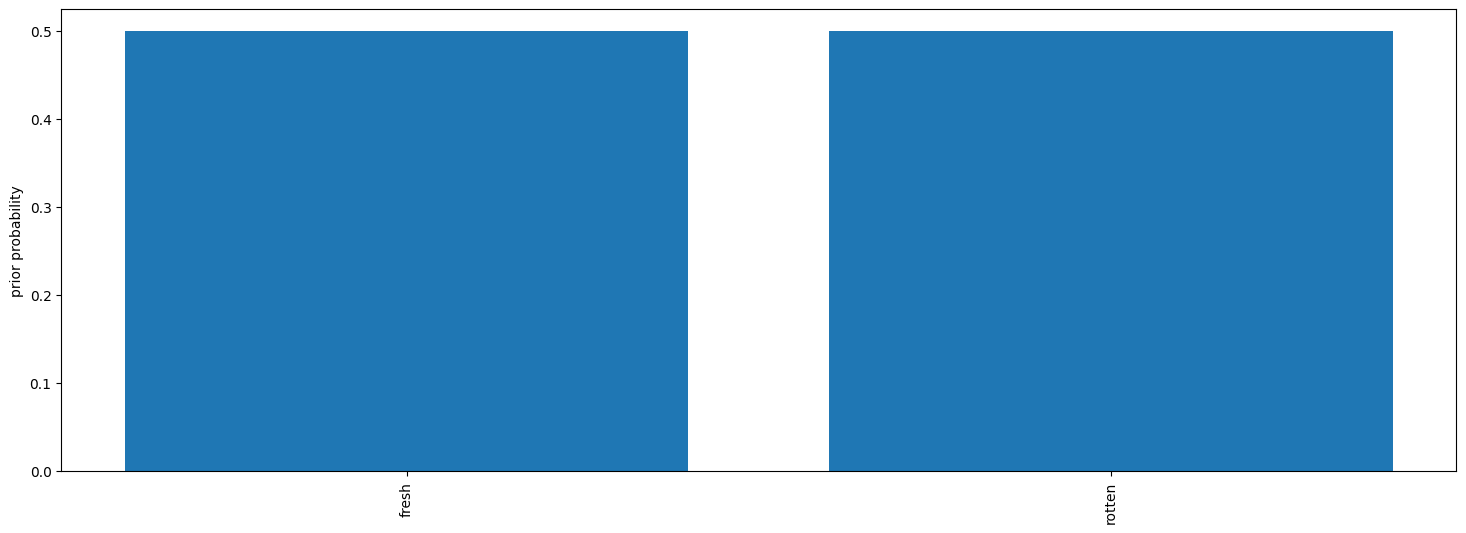

In [49]:
fig = plt.figure(figsize=(18, 6))
plt.bar(df_categorie_prior_prob['category'], df_categorie_prior_prob['prior_prob'])
_ = plt.xticks(rotation=90)
_ = plt.ylabel("prior probability")

# Do following experiments
# Compare the effect of Smoothing


Likelihood P(X1|Class), P(X2|Class), ........ P(X2|Class)


Probability of the word given a category/class



Smoothing


If a word does not exist in the category P(word|class) becomes 0.

This makes the posterior probability also to be zero, as the posterior probability P(Class|X1, X2, .....Xn) = P(X1|Class) * P(X2|Class) ........ P(X2|Class) * P(Class)
Laplace smoothing is applied to handle this issue.


A small-sample correction or pseudo-count is applied din every probability estimate.
We choose the smoothing parameter alpha = 1

In [50]:
# smoothing parameter
alpha = 1

In [51]:
# vocabulary size, the number of distinct words
n_vocabulary = len(vocabulary)
print(n_vocabulary)

6832


In [52]:
categories = df_categorie_prior_prob['category'].values
n_categories = len(categories)
print(n_categories)

2


In [53]:
P_word_catg = pd.DataFrame() 
for categorie in tqdm(categories):
  catg_X_train_feat = X_train_feat[y_train == categorie]
  catg_all_words_count = catg_X_train_feat.sum()
  catg_each_word_count = catg_X_train_feat.sum(axis=0)  
  catg_each_word_count = catg_each_word_count.flatten() + alpha
  catg_each_word_prob = catg_each_word_count/(catg_all_words_count + alpha*n_vocabulary)
  P_word_catg = pd.concat([P_word_catg, pd.DataFrame(catg_each_word_prob)])

P_word_catg.columns = vocabulary
P_word_catg.index = categories

print(P_word_catg.shape)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.01it/s]

(2, 6832)


# Derive Top 10 words that predicts each class
P[class | word] 


In [54]:
P_word_catg.head(2)

,it,s,a,pleasing,irony,that,this,study,of,one,...,confrontation,werner,stooges,spirits,wilderness,offend,belt,deaths,innovation,scarcely
fresh,0.020536,2.694066e-07,2.694066e-07,0.000110,0.000057,0.014699,0.008537,0.000310,0.035905,0.004665,...,0.000013,0.000021,0.000012,0.000022,0.000015,0.000007,0.000013,0.000007,0.000015,0.000011
rotten,0.021487,2.745366e-07,2.745366e-07,0.000051,0.000064,0.015114,0.009329,0.000117,0.032032,0.004151,...,0.000016,0.000013,0.000017,0.000013,0.000014,0.000022,0.000017,0.000025,0.000020,0.000019


In [55]:
def predict(X_feat, P_prior_catg, P_word_catg, categories):
    predictions = []
    P_word_catg_mat = P_word_catg.to_numpy()
    X_feat = X_feat.todense() 
    for news_feat in tqdm(X_feat):
        P_likelihood_news = np.multiply(news_feat, P_word_catg_mat)
        P_likelihood_news[P_likelihood_news == 0] = 1
        P_likelihood_news = np.prod(P_likelihood_news, axis=1).flatten()
        P_each_class_pred = np.multiply(P_likelihood_news, P_prior_catg.T) # multiply likelihood with prior prob
        categorie = categories[np.argmax(P_each_class_pred)]
        predictions.append(categorie)
        
    return predictions

In [56]:
y_train_pred = predict(X_train_feat, P_prior_catg, P_word_catg, categories)

100%|█████████████████████████████████| 384000/384000 [01:03<00:00, 6010.76it/s]


# Using the test dataset
# Use the optimal hyperparameters you found in the step e, and use it to calculate the final accuracy.  


In [57]:
print("overall occuracy")
print(accuracy_score(y_train, y_train_pred))

overall occuracy
0.7814505208333333


In [58]:
print("classification report")
print(classification_report(y_train, y_train_pred))

classification report
              precision    recall  f1-score   support

       fresh       0.79      0.76      0.78    192000
      rotten       0.77      0.80      0.79    192000

    accuracy                           0.78    384000
   macro avg       0.78      0.78      0.78    384000
weighted avg       0.78      0.78      0.78    384000



In [59]:
print("confusion matrix")
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

confusion matrix
[[146202  45798]
 [ 38125 153875]]


<AxesSubplot: >

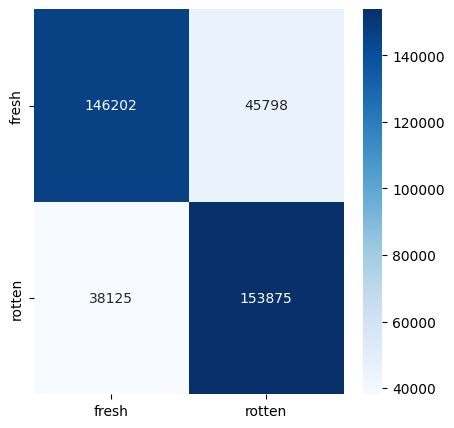

In [62]:
plt.figure(figsize = (5, 5))
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [64]:
y_test_pred = predict(X_test_feat, P_prior_catg, P_word_catg, categories)

100%|███████████████████████████████████| 48000/48000 [00:08<00:00, 5928.23it/s]


In [65]:
print("overall occuracy")
print(accuracy_score(y_test, y_test_pred))

overall occuracy
0.7770416666666666


In [66]:
print("classification report")
print(classification_report(y_test, y_test_pred))

classification report
              precision    recall  f1-score   support

       fresh       0.79      0.75      0.77     24000
      rotten       0.77      0.80      0.78     24000

    accuracy                           0.78     48000
   macro avg       0.78      0.78      0.78     48000
weighted avg       0.78      0.78      0.78     48000



In [67]:
print("confusion matrix")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

confusion matrix
[[18112  5888]
 [ 4814 19186]]


<AxesSubplot: >

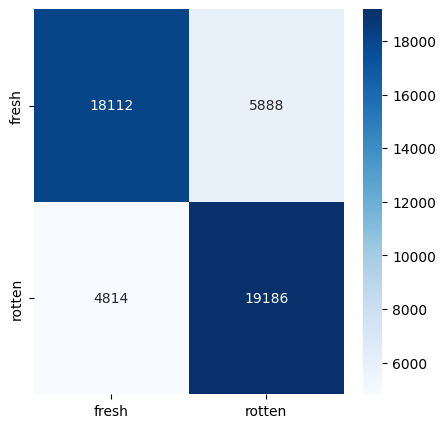

In [69]:
plt.figure(figsize = (5, 5))
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

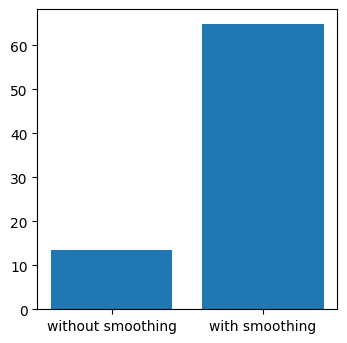

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0,0,1,1])
langs = ['without smoothing','with smoothing']
students = [13.45,64.96]
ax.bar(langs,students)
plt.show()